In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

def download_and_clean_data(ticker='SPY', period='10y'):
    print(f"downloading {ticker} data")

    # Download data
    data= yf.download(ticker, period=period, progress=False, auto_adjust=True)

    new_cols= []
    if isinstance(data.columns, pd.MultiIndex) or any(isinstance(c, tuple) for c in data.columns):
        new_cols = [col[0] if isinstance(col, tuple) else col for col in data.columns]
    else:
        new_cols= data.columns.tolist()

    new_cols = [str(col).replace(' ', '_').capitalize() for col in new_cols]
    data.columns = new_cols

    print(f"downloaded {len(data)} days of data")
    print(f"columns: {list(data.columns)}")
    print(f"date range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")

    return data

data = download_and_clean_data('SPY', '10y')
print("\nfirst 3 rows:")
print(data.head(3))

downloading SPY data
downloaded 2515 days of data
columns: ['Close', 'High', 'Low', 'Open', 'Volume']
date range: 2015-10-28 to 2025-10-28

first 3 rows:
                 Close        High         Low        Open     Volume
Date                                                                 
2015-10-28  176.565659  176.591008  174.250329  174.917884  135906700
2015-10-29  176.464188  176.835996  175.940283  176.058585   90525500
2015-10-30  175.703720  176.979699  175.543178  176.658590  131076900


In [6]:
def create_features(data):
    features= pd.DataFrame(index=data.index)

    # find the correct column names 
    close_col = 'Close'
    volume_col = 'Volume'

    if close_col not in data.columns:
        raise ValueError("could not find 'Close' price column")
    if volume_col not in data.columns:
        volume_col = None 


    print(f"using column '{close_col}' for price data")

    # calculate returns
    features['returns']= data[close_col].pct_change()

    # create momentum features (added 50d, 200d)
    features['momentum_5d']= data[close_col].pct_change(5)
    features['momentum_21d']= data[close_col].pct_change(21)
    features['momentum_50d']= data[close_col].pct_change(50)
    features['momentum_200d']= data[close_col].pct_change(200)


    # create volatility features (added 50d, 200d)
    features['volatility_5d']= features['returns'].rolling(5).std()
    features['volatility_21d']= features['returns'].rolling(21).std()
    features['volatility_50d']= features['returns'].rolling(50).std()
    features['volatility_200d']= features['returns'].rolling(200).std()


    # moving average features (added 21/50, 50/200)
    ma_5= data[close_col].rolling(5).mean()
    ma_21= data[close_col].rolling(21).mean()
    ma_50= data[close_col].rolling(50).mean()
    ma_200= data[close_col].rolling(200).mean()

    features['MA_5_21_ratio']= ma_5 / ma_21
    features['MA_21_50_ratio']= ma_21 / ma_50
    features['MA_50_200_ratio']= ma_50 / ma_200


    # volume feature (if available)
    if volume_col:
        features['volume_ratio']= (data[volume_col] /
                                   data[volume_col].rolling(21).mean())

    # target: next days return
    features['target']= features['returns'].shift(-1)

    
    features_clean= features.iloc[200:-1].copy()

    print(f"created {len(features_clean)} samples with {len(features_clean.columns)} features")
    return features_clean

features= create_features(data)
print("\nfeature summary:")
print(features.describe())

using column 'Close' for price data
created 2314 samples with 14 features

feature summary:
           returns  momentum_5d  momentum_21d  momentum_50d  momentum_200d  \
count  2314.000000  2314.000000   2314.000000   2314.000000    2314.000000   
mean      0.000627     0.003051      0.012761      0.030277       0.119696   
std       0.011531     0.023499      0.046112      0.065516       0.119274   
min      -0.109424    -0.179693     -0.327513     -0.313451      -0.244252   
25%      -0.003626    -0.006579     -0.007165      0.005893       0.057980   
50%       0.000711     0.004844      0.019211      0.038044       0.126712   
75%       0.005986     0.015152      0.038313      0.066646       0.186918   
max       0.105019     0.173581      0.251850      0.400224       0.696799   

       volatility_5d  volatility_21d  volatility_50d  volatility_200d  \
count    2314.000000     2314.000000     2314.000000      2314.000000   
mean        0.008887        0.009481        0.009848       

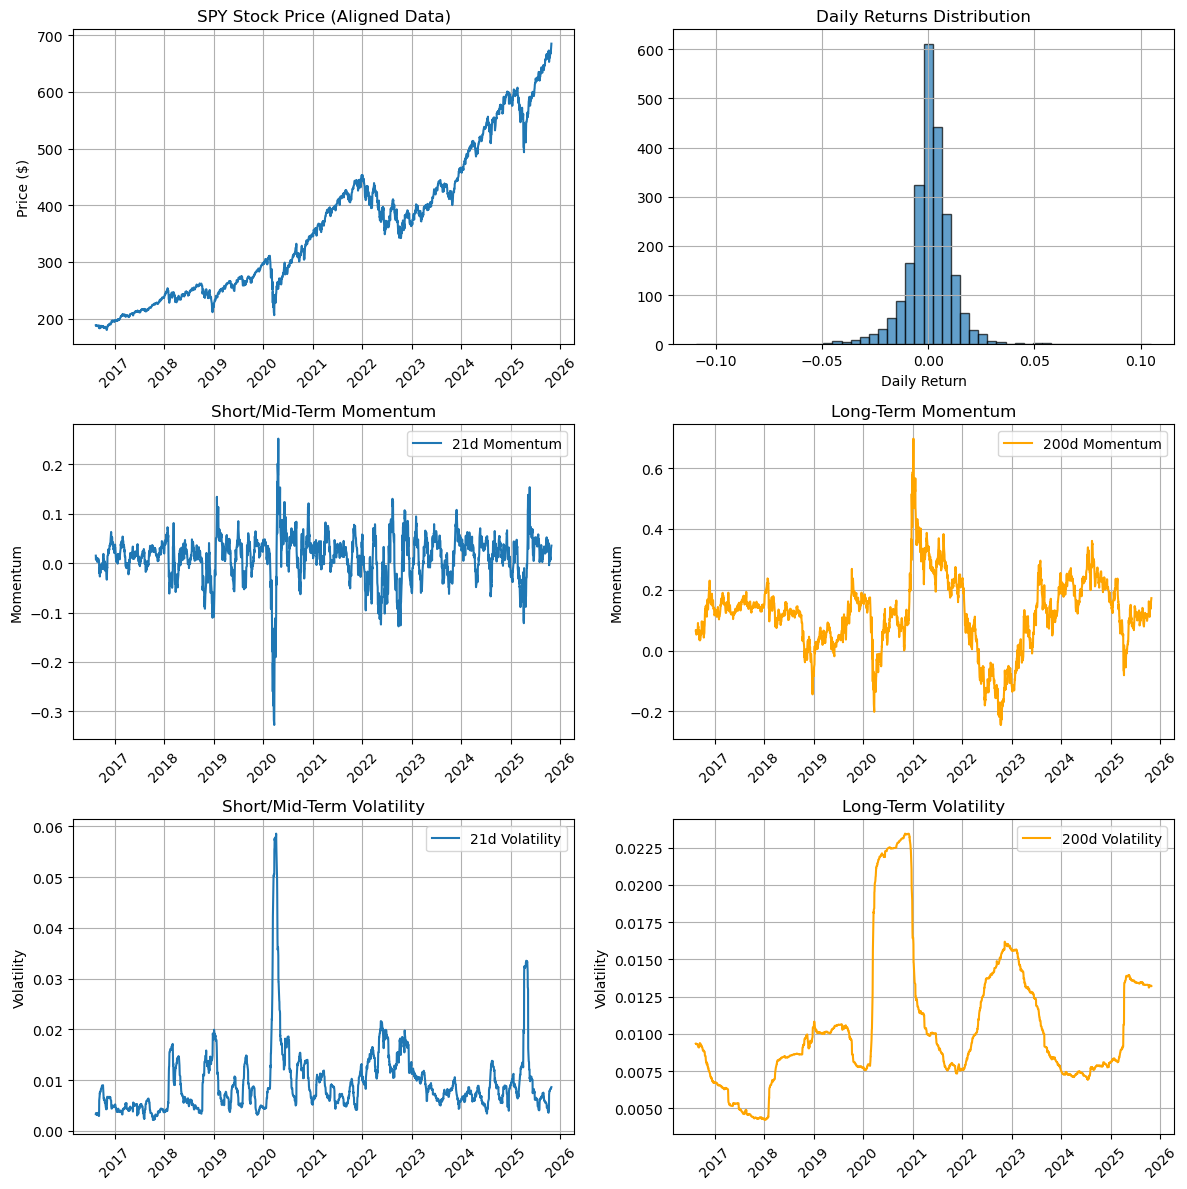

correlation with target (next day return):
target             1.0000
volatility_50d     0.0389
volatility_200d    0.0364
volatility_21d     0.0296
volume_ratio      -0.0139
MA_5_21_ratio     -0.0197
MA_50_200_ratio   -0.0250
momentum_21d      -0.0273
momentum_200d     -0.0299
volatility_5d     -0.0380
MA_21_50_ratio    -0.0437
momentum_5d       -0.0484
momentum_50d      -0.0499
returns           -0.1401
Name: target, dtype: float64


In [7]:
def create_visualizations(data, features):
    aligned_data= data.loc[features.index]
    close_col= 'Close'

    fig, axes= plt.subplots(3, 2, figsize=(12, 12)) 

    # stock price
    axes[0,0].plot(aligned_data.index, aligned_data[close_col])
    axes[0,0].set_title(f'SPY Stock Price (Aligned Data)')
    axes[0,0].set_ylabel('Price ($)')
    axes[0,0].grid(True)
    axes[0,0].tick_params(axis='x', rotation=45)

    # returns distribution
    axes[0,1].hist(features['returns'].dropna(), bins=50, alpha=0.7, edgecolor='black')
    axes[0,1].set_title('Daily Returns Distribution')
    axes[0,1].set_xlabel('Daily Return')
    axes[0,1].grid(True)

    # Short-term momentum
    axes[1,0].plot(features.index, features['momentum_21d'], label='21d Momentum')
    axes[1,0].set_title('Short/Mid-Term Momentum')
    axes[1,0].set_ylabel('Momentum')
    axes[1,0].grid(True)
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].legend()


    # Long-term momentum
    axes[1,1].plot(features.index, features['momentum_200d'], label='200d Momentum', color='orange')
    axes[1,1].set_title('Long-Term Momentum')
    axes[1,1].set_ylabel('Momentum')
    axes[1,1].grid(True)
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].legend()

    # Short-term volatility
    axes[2,0].plot(features.index, features['volatility_21d'], label='21d Volatility')
    axes[2,0].set_title('Short/Mid-Term Volatility')
    axes[2,0].set_ylabel('Volatility')
    axes[2,0].grid(True)
    axes[2,0].tick_params(axis='x', rotation=45)
    axes[2,0].legend()

    # Long-term volatility
    axes[2,1].plot(features.index, features['volatility_200d'], label='200d Volatility', color='orange')
    axes[2,1].set_title('Long-Term Volatility')
    axes[2,1].set_ylabel('Volatility')
    axes[2,1].grid(True)
    axes[2,1].tick_params(axis='x', rotation=45)
    axes[2,1].legend()

    plt.tight_layout()
    plt.show()

    # correlation analysis
    correlation_with_target= features.corr()['target'].sort_values(ascending=False)
    print("correlation with target (next day return):")
    print(correlation_with_target.round(4))

create_visualizations(data, features)

In [8]:
print("\ndata quality check:")
print(f"total original data points: {len(data)}")
print(f"total feature data points after NaN drop: {len(features)}")
print(f"feature columns: {list(features.columns)}")

# check for any missing values in the final features df
print(f"\nmissing values in final features:")
print(features.isnull().sum())

# basic statistics of the final target variable
print(f"\ntarget variable statistics (final features df):")
print(f"mean: {features['target'].mean():.6f}")
print(f"std:  {features['target'].std():.6f}")
print(f"min:  {features['target'].min():.6f}")
print(f"max:  {features['target'].max():.6f}")


data quality check:
total original data points: 2515
total feature data points after NaN drop: 2314
feature columns: ['returns', 'momentum_5d', 'momentum_21d', 'momentum_50d', 'momentum_200d', 'volatility_5d', 'volatility_21d', 'volatility_50d', 'volatility_200d', 'MA_5_21_ratio', 'MA_21_50_ratio', 'MA_50_200_ratio', 'volume_ratio', 'target']

missing values in final features:
returns            0
momentum_5d        0
momentum_21d       0
momentum_50d       0
momentum_200d      0
volatility_5d      0
volatility_21d     0
volatility_50d     0
volatility_200d    0
MA_5_21_ratio      0
MA_21_50_ratio     0
MA_50_200_ratio    0
volume_ratio       0
target             0
dtype: int64

target variable statistics (final features df):
mean: 0.000626
std:  0.011531
min:  -0.109424
max:  0.105019
